## **Imports**

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from google.colab import drive
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import random
import sys
import os


In [2]:
# mount drive folder and import custom modules
drive.mount('/content/drive', force_remount=False)
sys.path.insert(0,'/content/drive/MyDrive/Shark_Classification')

Mounted at /content/drive


## **Read Images and Preprocess**

In [9]:
# build path to dataset
dataset_path = os.path.join(sys.path[0],'sharks')
output_path= os.path.join(sys.path[0],"output")

# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
annotations_csv = os.path.join(dataset_path,'shark_annotation.csv')
rows = open(annotations_csv).read().strip().split("\n")

# initialize the lists
data = []
targets = []
filenames = []

# loop over the rows
for row in rows:
  # break the row into the filename and bounding box coordinates
  row = row.split(",")
  (filename, label, startX, startY, endX, endY) = row

  # build the path to the image and read it
  image_path = os.path.join(dataset_path,label,filename)
  image = cv2.imread(image_path)

  # skip if there was a problem loading the image
  if image is None: continue

  # scale the bounding box coordinates relative to the spatial
  # dimensions of the input image
  (h, w) = image.shape[:2]
  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h
  
  # load the image and preprocess it
  image = load_img(image_path, target_size=(224, 224))
  image = img_to_array(image)
	
  # update our list of data, targets, and filenames
  data.append(image)
  targets.append((startX, startY, endX, endY))
  filenames.append(filename)

[INFO] loading dataset...


In [10]:
print(len(data))

747


### **Train/Test Split**

In [11]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

##**Define Model and Compile**

In [34]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 1e-5
EPOCHS = 50
BS = 32

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers
baseModel.trainable = False

# flatten the max-pooling output of VGG
flatten = baseModel.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=bboxHead)

#compiling the model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())


[INFO] compiling model...
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (Non

##**Train Model**

### **Callbacks**

In [35]:
# define early stopping callback
callback= EarlyStopping(
          monitor="val_loss",
          patience=10,
          mode="auto",
          restore_best_weights=True,
          )

### **Train**

In [36]:
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BS,
    epochs=EPOCHS,
    callbacks = [callback],
    verbose=1)


[INFO] training bounding box regressor...
Epoch 1/50
21/21 [==============================] - 7s 289ms/step - loss: 0.1120 - val_loss: 0.0807
Epoch 2/50
21/21 [==============================] - 5s 261ms/step - loss: 0.0647 - val_loss: 0.0526
Epoch 3/50
21/21 [==============================] - 5s 262ms/step - loss: 0.0414 - val_loss: 0.0373
Epoch 4/50
21/21 [==============================] - 5s 262ms/step - loss: 0.0304 - val_loss: 0.0304
Epoch 5/50
21/21 [==============================] - 5s 264ms/step - loss: 0.0257 - val_loss: 0.0275
Epoch 6/50
21/21 [==============================] - 5s 263ms/step - loss: 0.0234 - val_loss: 0.0257
Epoch 7/50
21/21 [==============================] - 5s 263ms/step - loss: 0.0219 - val_loss: 0.0245
Epoch 8/50
21/21 [==============================] - 5s 262ms/step - loss: 0.0210 - val_loss: 0.0238
Epoch 9/50
21/21 [==============================] - 5s 264ms/step - loss: 0.0202 - val_loss: 0.0231
Epoch 10/50
21/21 [==============================] - 5s 26

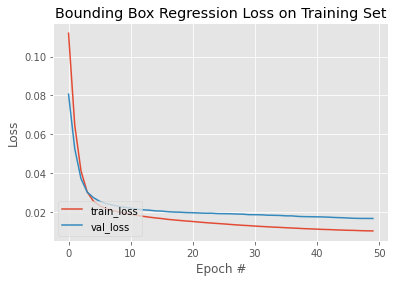

In [39]:
# plot the model training history
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(os.path.join(output_path,"vggnet_bbregression_loss.jpg"))

##**Save the Model**

In [40]:
# save the model and label binarizer to disk
save = True
if save:
  print("[INFO] saving model...")
  model.save(os.path.join(output_path,'vggnet_bbregression.model'), save_format="h5")

[INFO] saving model...
